In [140]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [141]:
drug = 'acetamin RXs'

In [142]:
df = pd.read_csv('/Users/albert/Documents/Capstone/test copy.csv')
df['Unnamed: 0']=df['Unnamed: 0'].astype('datetime64')
df.set_index('Unnamed: 0',drop=True,inplace=True)
df.index.name = None
df.sort_index(inplace=True)

In [144]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [145]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

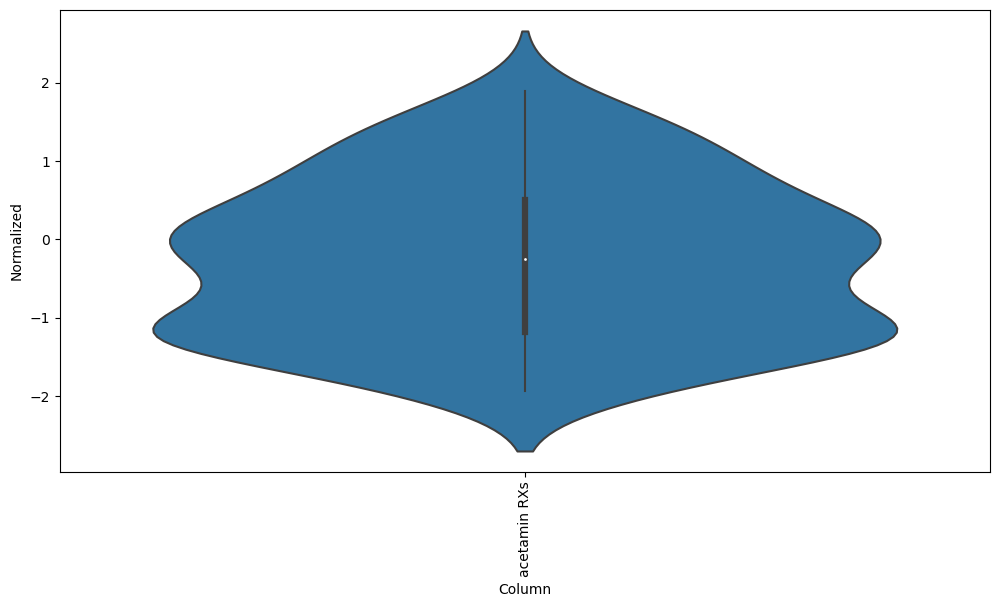

In [146]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [147]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [148]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=[f'{drug}'])
w1

w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=[f'{drug}'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['acetamin RXs']

In [149]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [150]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[11:11+w2.total_window_size]),
                           np.array(train_df[17:17+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


In [151]:
w2.example = example_inputs, example_labels

In [152]:
def plot(self, model=None, plot_col=f'{drug}', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel(f'{drug}')

WindowGenerator.plot = plot

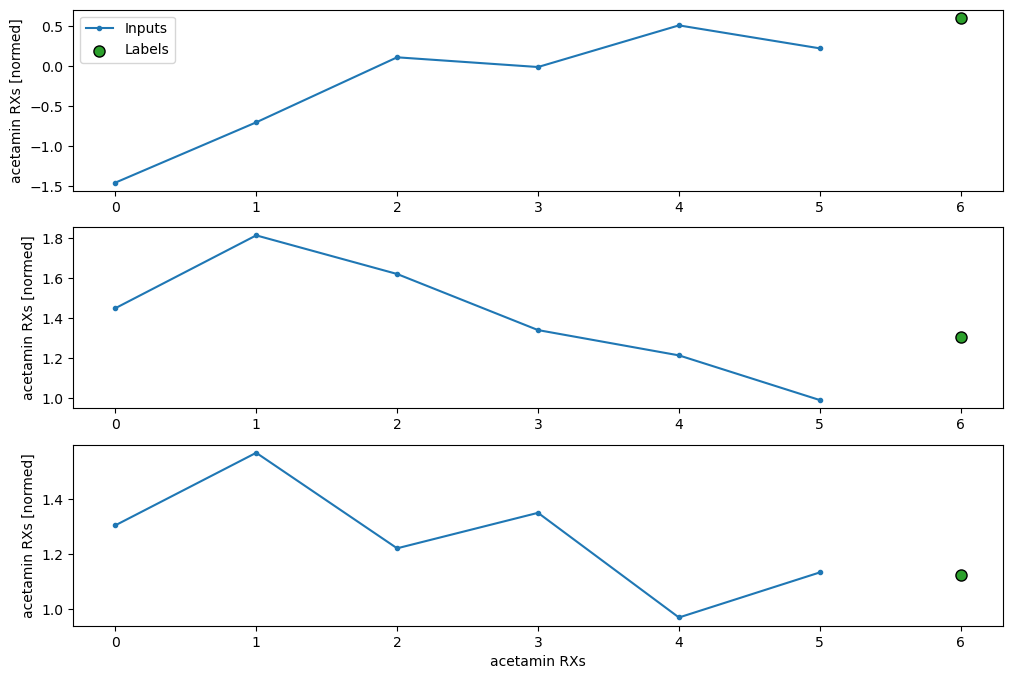

In [153]:
w2.plot()

In [154]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [155]:
### Test lines

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Each element is an (inputs, label) pair.
display(w2.train.element_spec)

for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [156]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[f'{drug}'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['acetamin RXs']

In [157]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [158]:
### BASELINE FOR COMPARISON

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [159]:
baseline = Baseline(label_index=column_indices[f'{drug}'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 80ms/step - loss: 0.0532 - mean_absolute_error: 0.1926


In [160]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[f'{drug}'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['acetamin RXs']

In [161]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


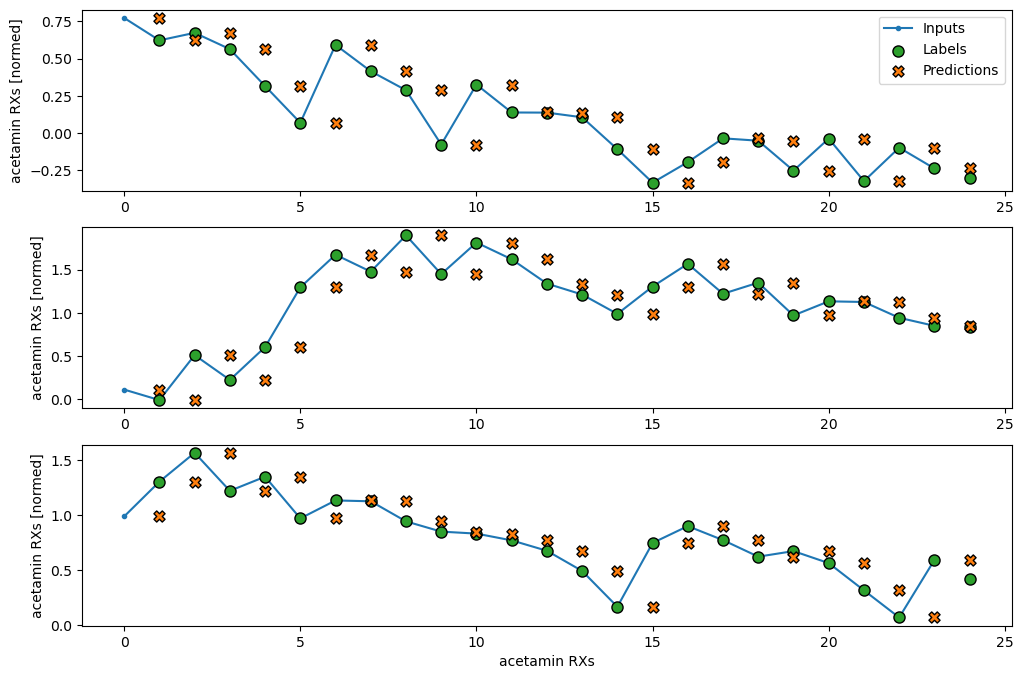

In [162]:
wide_window.plot(baseline)

In [163]:
### INSTANTIATE LINEAR NN

linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 1)
Output shape: (32, 1, 1)
Epoch 1/20
3/3 [==============================] - 0s 35ms/step - loss: 0.1689 - mean_absolute_error: 0.3197 - val_loss: 0.0814 - val_mean_absolute_error: 0.2547
Epoch 2/20
3/3 [==============================] - 0s 16ms/step - loss: 0.1674 - mean_absolute_error: 0.3177 - val_loss: 0.0807 - val_mean_absolute_error: 0.2537
Epoch 3/20
3/3 [==============================] - 0s 16ms/step - loss: 0.1659 - mean_absolute_error: 0.3159 - val_loss: 0.0798 - val_mean_absolute_error: 0.2526
Epoch 4/20
3/3 [==============================] - 0s 16ms/step - loss: 0.1642 - mean_absolute_error: 0.3140 - val_loss: 0.0791 - val_mean_absolute_error: 0.2517
Epoch 5/20
3/3 [==============================] - 0s 15ms/step - loss: 0.1629 - mean_absolute_error: 0.3124 - val_loss: 0.0785 - val_mean_absolute_error: 0.2509
Epoch 6/20
3/3 [==============================] - 0s 16ms/step - loss: 0.1615 - mean_absolute_error: 0.3106 - val_loss: 0.0778 - val_mean_absolute

In [243]:
MAX_EPOCHS = 2000

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Epoch 1/2000
3/3 [==============================] - 0s 38ms/step - loss: 0.1427 - mean_absolute_error: 0.2878 - val_loss: 0.0680 - val_mean_absolute_error: 0.2357
Epoch 2/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.1416 - mean_absolute_error: 0.2865 - val_loss: 0.0676 - val_mean_absolute_error: 0.2352
Epoch 3/2000
3/3 [==============================] - 0s 15ms/step - loss: 0.1404 - mean_absolute_error: 0.2849 - val_loss: 0.0671 - val_mean_absolute_error: 0.2343
Epoch 4/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.1392 - mean_absolute_error: 0.2834 - val_loss: 0.0666 - val_mean_absolute_error: 0.2335
Epoch 5/2000
3/3 [==============================] - 0s 28ms/step - loss: 0.1381 - mean_absolute_error: 0.2819 - val_loss: 0.0660 - val_mean_absolute_error: 0.2326
Epoch 6/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.1370 - mean_absolute_error: 0.2805 - val_loss: 0.0655 - val_mean_absolute_error: 0.2316
Epoch 7/2000
3/3 [====

In [ ]:

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


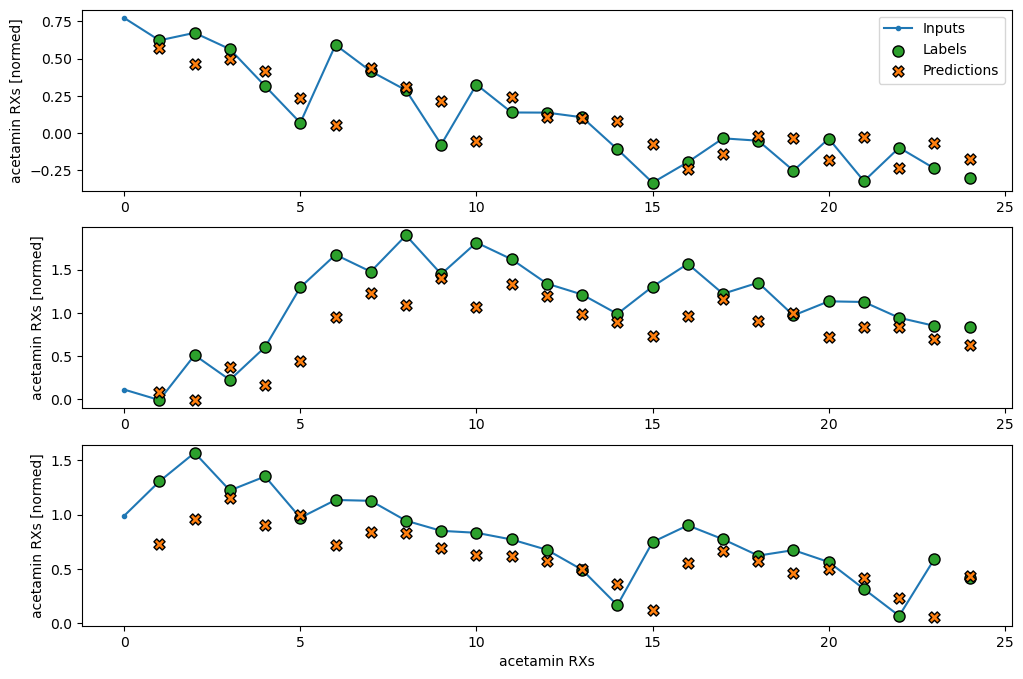

In [164]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

wide_window.plot(linear)

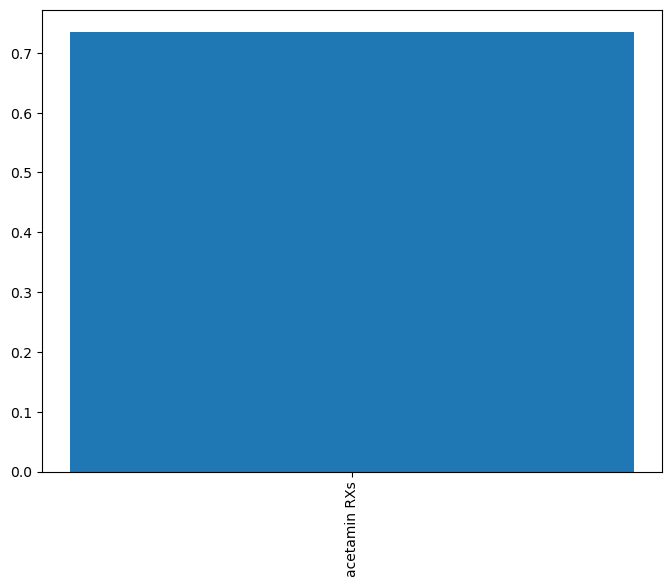

In [165]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [166]:
### DENSE RELU ONE STEP

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
3/3 [==============================] - 0s 44ms/step - loss: 1.0246 - mean_absolute_error: 0.8340 - val_loss: 0.7079 - val_mean_absolute_error: 0.6425
Epoch 2/20
3/3 [==============================] - 0s 16ms/step - loss: 0.8660 - mean_absolute_error: 0.7602 - val_loss: 0.6080 - val_mean_absolute_error: 0.6019
Epoch 3/20
3/3 [==============================] - 0s 16ms/step - loss: 0.7209 - mean_absolute_error: 0.6874 - val_loss: 0.5175 - val_mean_absolute_error: 0.5616
Epoch 4/20
3/3 [==============================] - 0s 16ms/step - loss: 0.6068 - mean_absolute_error: 0.6236 - val_loss: 0.4360 - val_mean_absolute_error: 0.5217
Epoch 5/20
3/3 [==============================] - 0s 16ms/step - loss: 0.5004 - mean_absolute_error: 0.5593 - val_loss: 0.3678 - val_mean_absolute_error: 0.4860
Epoch 6/20
3/3 [==============================] - 0s 16ms/step - loss: 0.4126 - mean_absolute_error: 0.5021 - val_loss: 0.3070 - val_mean_absolute_error: 0.4525
Epoch 7/20
3/3 [==================

1/1 [==============================] - 0s 30ms/step - loss: 0.1065 - mean_absolute_error: 0.2879


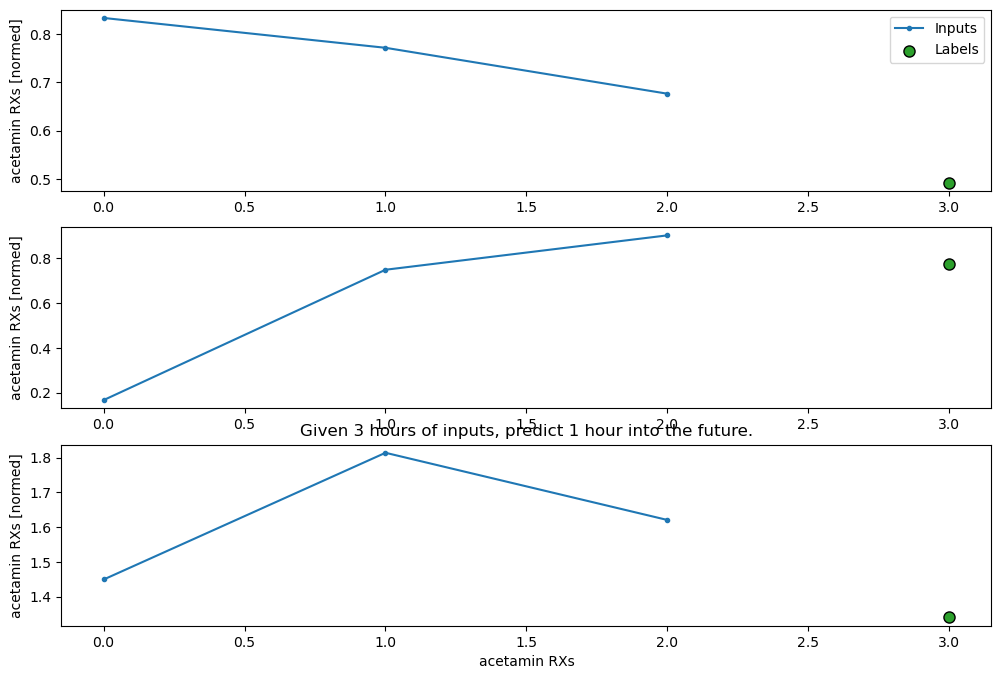

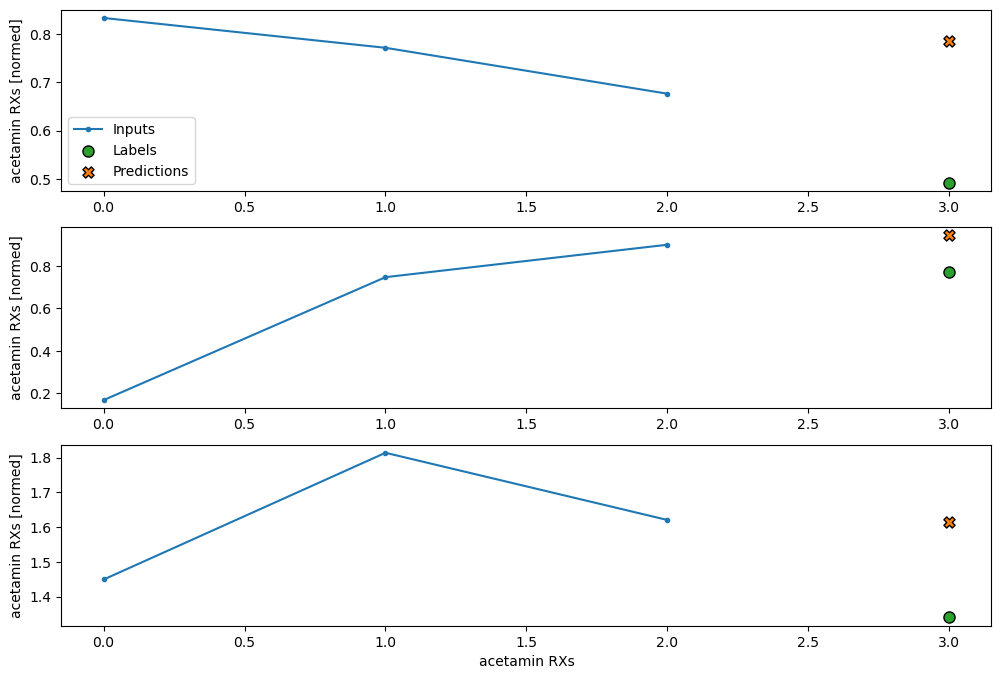

In [167]:
### DENSE RELU MULTI STEP

CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[f'{drug}'])

display(conv_window)

conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

conv_window.plot(multi_step_dense)

In [168]:
### DENSE RELU CNN

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[f'{drug}'])

wide_conv_window

1/1 [==============================] - 0s 30ms/step - loss: 0.0933 - mean_absolute_error: 0.2606
Wide window
Input shape: (32, 24, 1)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['acetamin RXs']

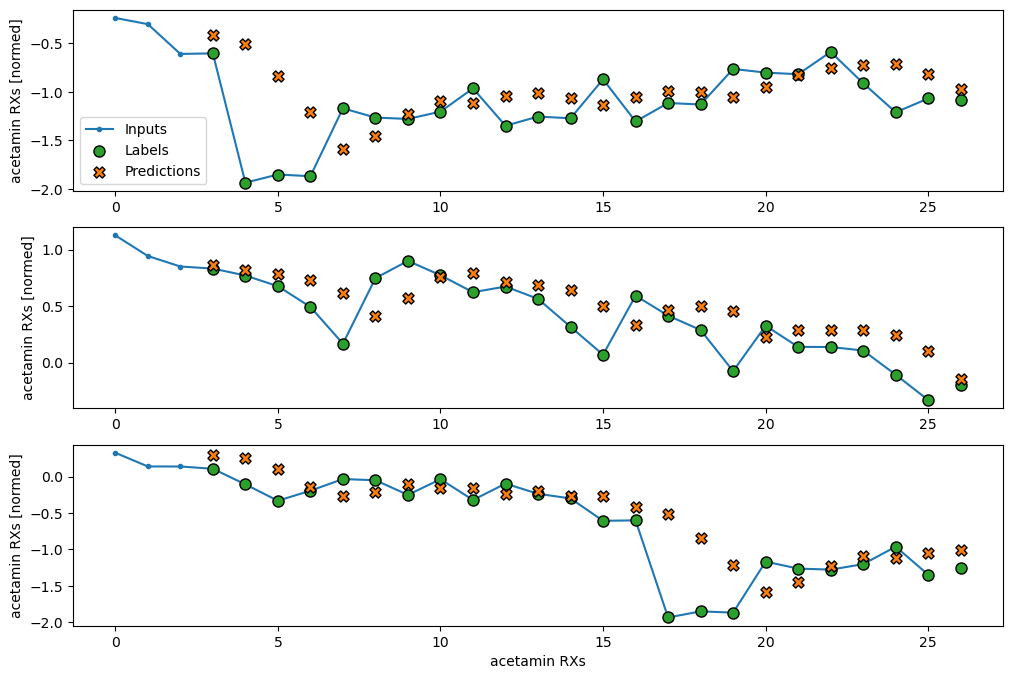

In [169]:
# each time step depends on the 3 before it

wide_conv_window.plot(conv_model)

1/1 [==============================] - 0s 35ms/step - loss: 0.4525 - mean_absolute_error: 0.5633


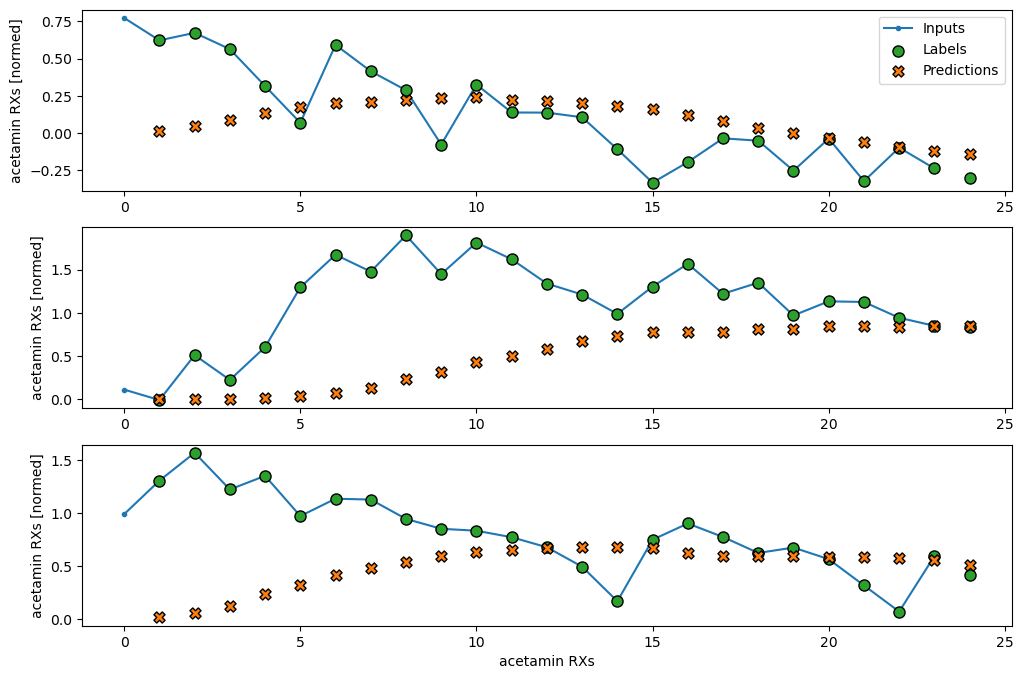

In [191]:
### DENSE RELU MULTI STEP RNN - ### THIS PERFORMANCE METRIC ISNT CALCULATING CORRECTLY

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = [1,1] #lstm_model.evaluate(wide_window.test, verbose=0)

wide_window.plot(lstm_model)

Baseline    : 0.1243
Linear      : 0.4084
Dense       : 0.1650
Multi step dense: 0.3042
Conv        : 0.2681
LSTM        : 1.0000


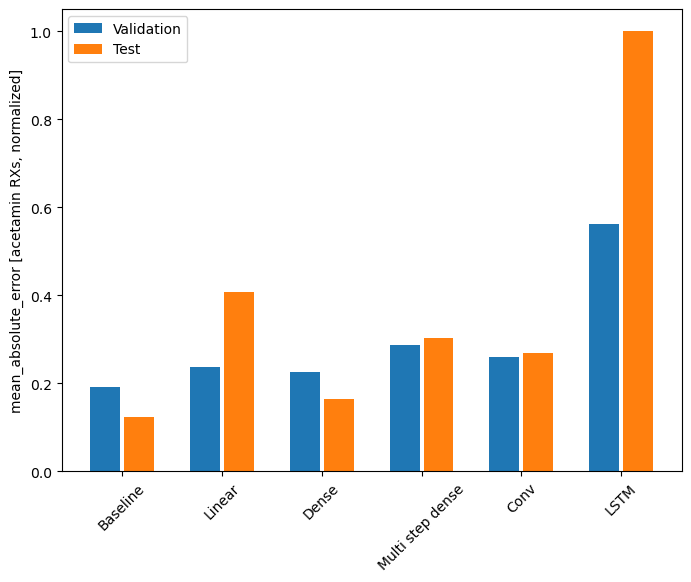

In [193]:
### SINGLE STEP METRICS

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel(f'mean_absolute_error [{drug}, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

# MULTISTEP MODELS

In [220]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 1)
Labels shape (batch, time, features): (32, 24, 1)


In [221]:
# BASELINE MEASUREMENT MULTISTEP

baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 62ms/step - loss: 0.0532 - mean_absolute_error: 0.1926


In [222]:
### DENSE

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 31ms/step - loss: 0.0725 - mean_absolute_error: 0.2283


In [223]:
### RNN

# %%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = [1,1] #lstm_model.evaluate( wide_window.test, verbose=0)

print()

1/1 [==============================] - 0s 29ms/step - loss: 0.4335 - mean_absolute_error: 0.5448



In [224]:
### RESNET

class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta
  
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = [1,1] #residual_lstm.evaluate(wide_window.test, verbose=0)
print()

1/1 [==============================] - 0s 37ms/step - loss: 0.0495 - mean_absolute_error: 0.1869



In [225]:
# ### MULTISTEP PERFORMANCE

# x = np.arange(len(performance))
# width = 0.3

# metric_name = 'mean_absolute_error'
# metric_index = lstm_model.metrics_names.index('mean_absolute_error')
# val_mae = [v[metric_index] for v in val_performance.values()]
# test_mae = [v[metric_index] for v in performance.values()]

# plt.bar(x - 0.17, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
# plt.xticks(ticks=x, labels=performance.keys(),
#            rotation=45)
# plt.ylabel('MAE (average over all outputs)')
# _ = plt.legend()

# for name, value in performance.items():
#   print(f'{name:15s}: {value[1]:0.4f}')

IndexError: list index out of range

# PREDICT FUTURE STEPS

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

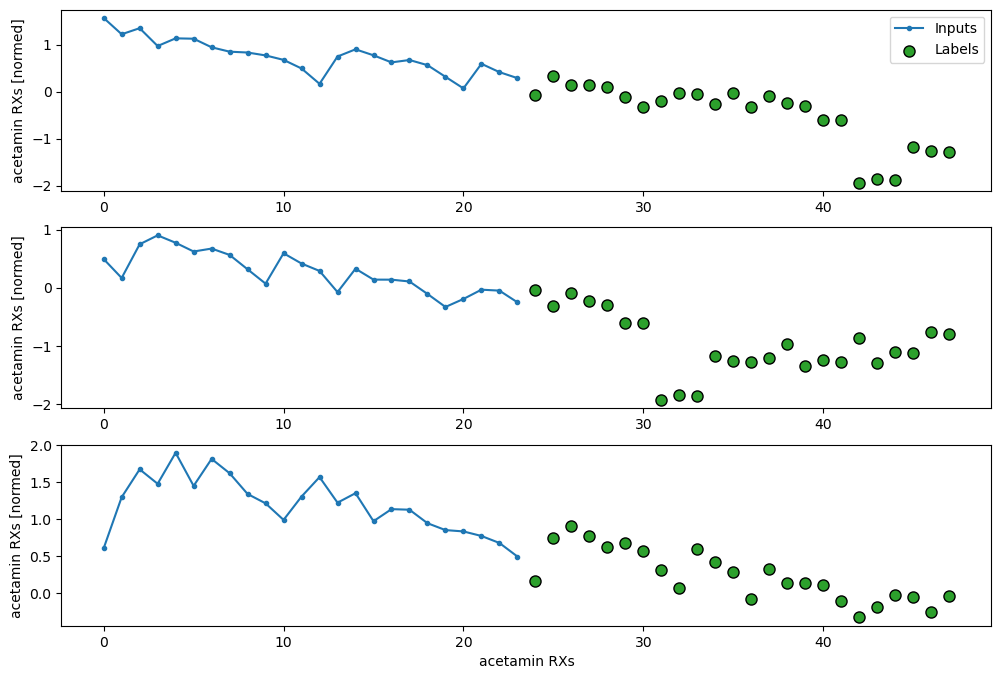

In [227]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

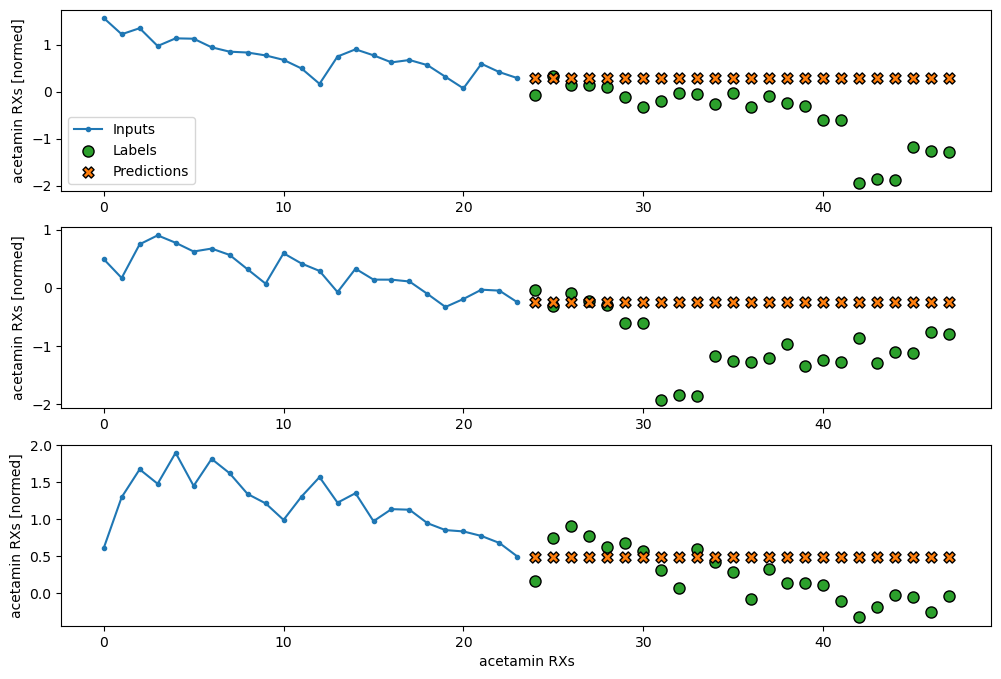

In [234]:
# baseline

class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

# multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
# multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

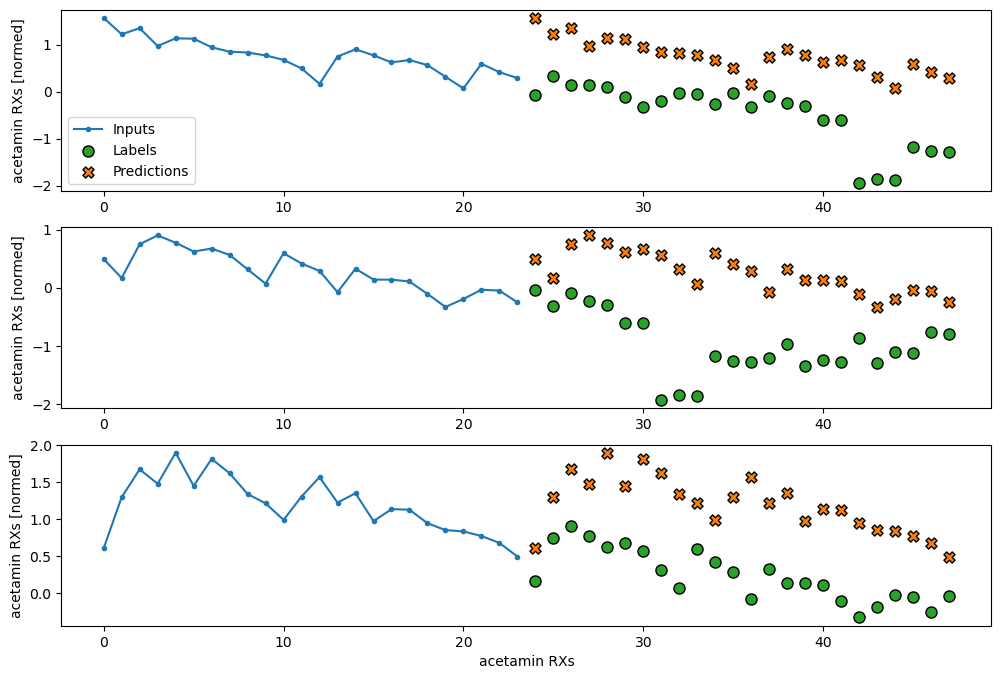

In [233]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

# multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
# multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

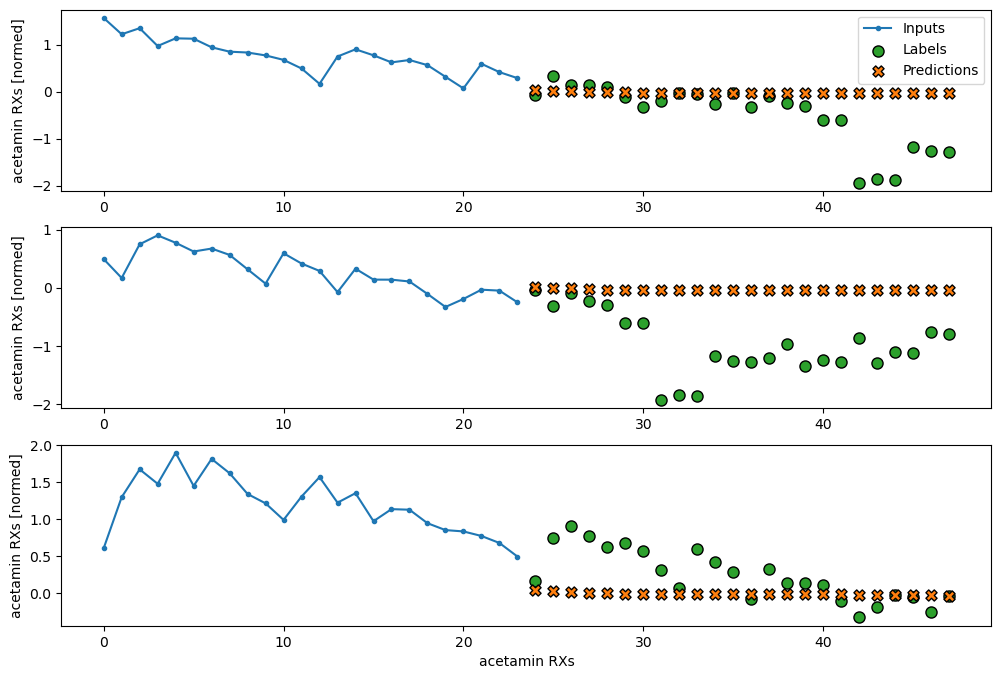

In [232]:
### single shot multistep linear

multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
# multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
# multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

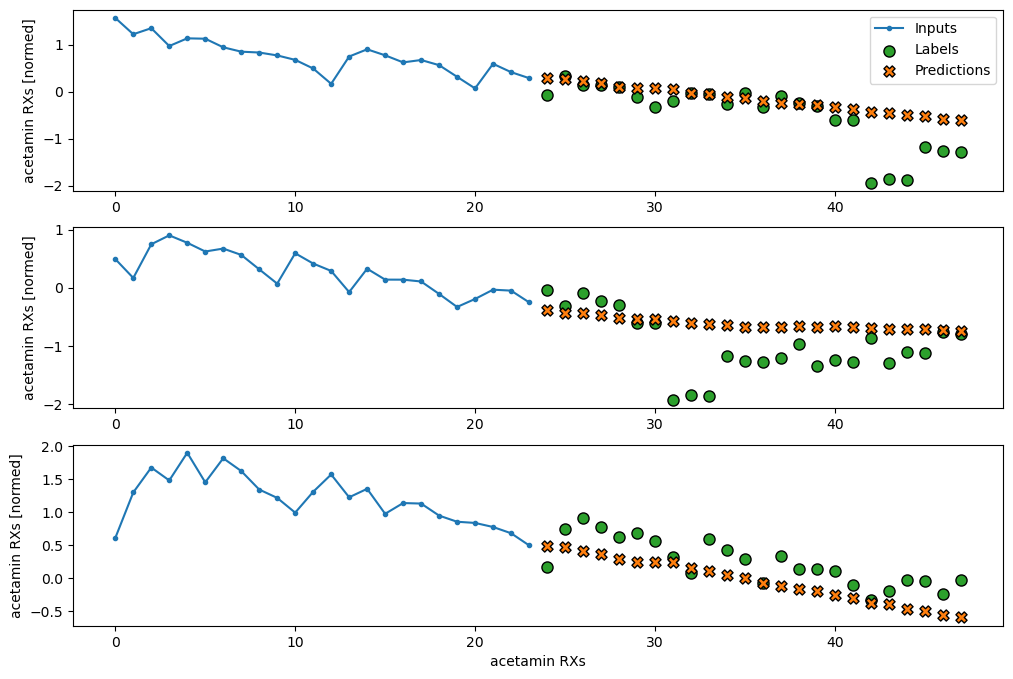

In [235]:
### single shot multistep dense

multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
# multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
# multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

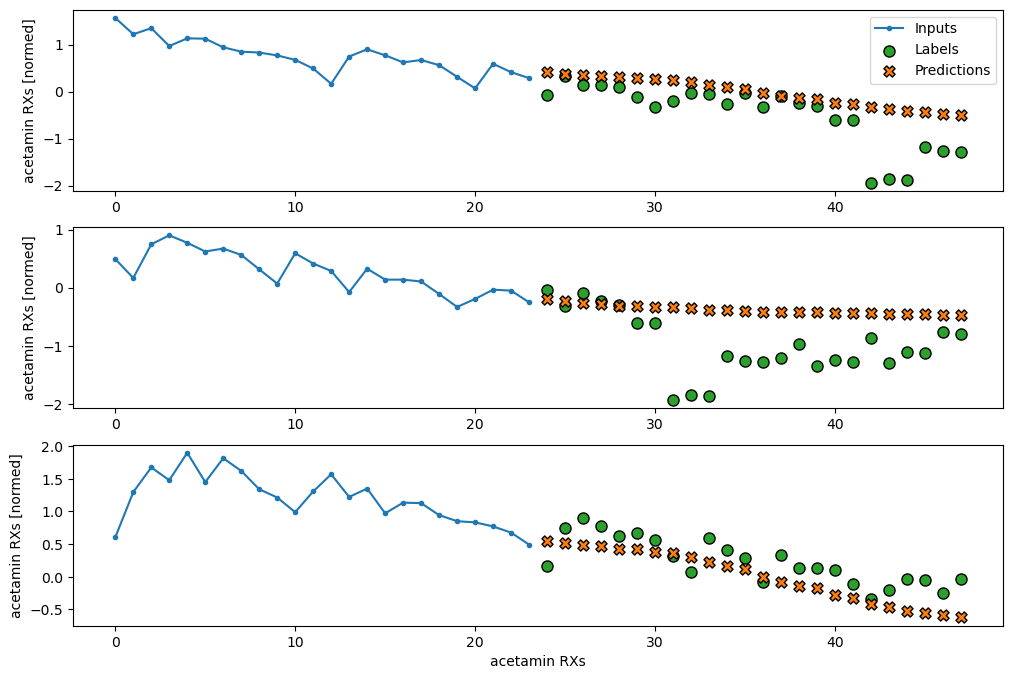

In [236]:
### single shot multistep CNN

CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

# multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
# multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

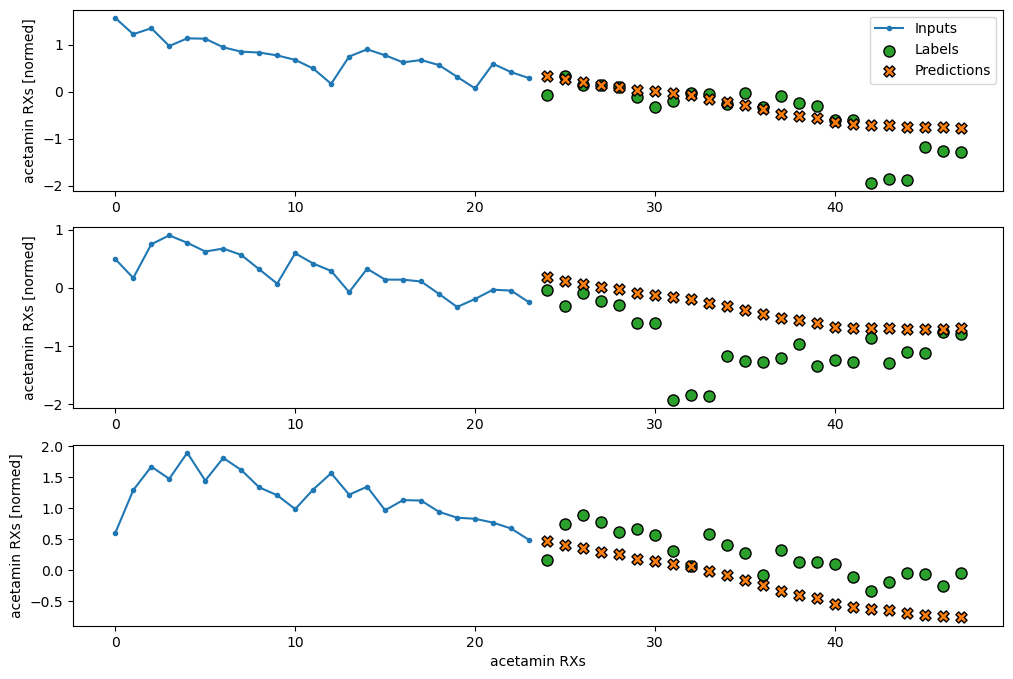

In [237]:
### single shot multistep RNN

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

# multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
# multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
### AUTOREGRESSIVE RNN

In [238]:
# ITS FIRST STEP

class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [239]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 1)


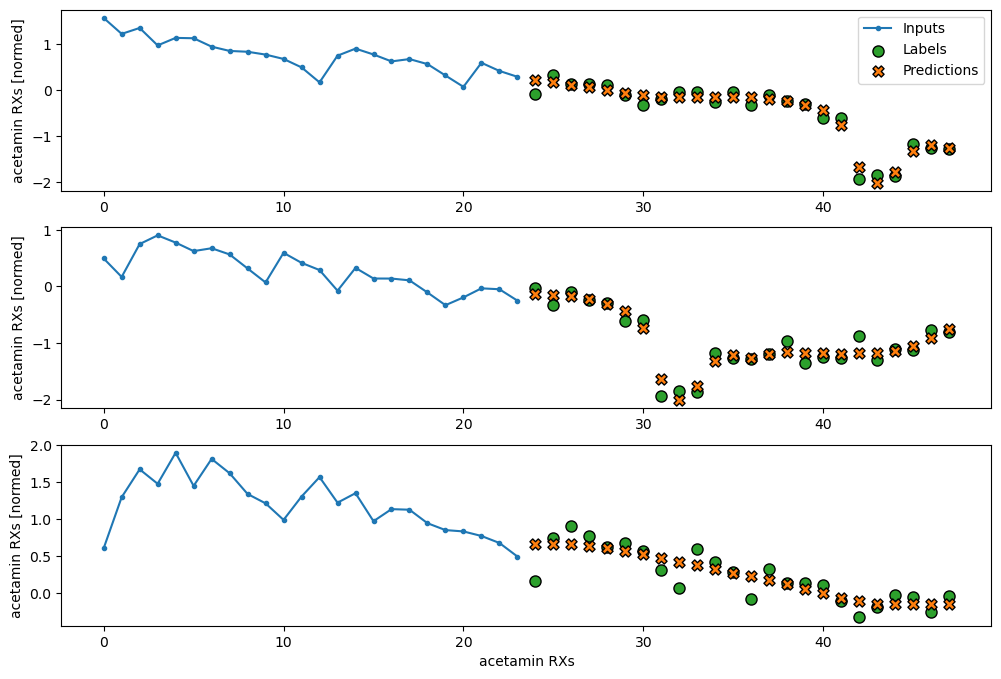

In [244]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

# multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
# multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)